In [1]:
# Date: 06-10-2021
# Author: Joshua Soutelo Vieira

### Histograms in computer vision

Why are histograms so useful? They capture the frequency distribution of pixel intensity values.

In [2]:
import os
import json

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [91]:
def grab_fields():
    toret = {}
    
    for field in fields:
        name = field['field']
        x = field['coord_pixel'][0]
        y = field['coord_pixel'][1]
        w = field['width']
        h = field['height']
    
        form_field = form[y:y+h, x:x+w]
        toret[name] = form_field
    
    return toret

def grab_fields_coords(file):
    with open(file, "r") as f:
        content = json.loads(f.read())

    return content 

def show_image(image, name=None, true_size=False):
    image = image.astype('uint8')
    if true_size:
        show_image_true_size(image, name=name)
    else:
        plt.title(name)
        plt.xlabel(str(image.shape[1]) + " px")
        plt.ylabel(str(image.shape[0]) + " px")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    
def show_image_true_size(image, name=None):
    dpi = 80
    height, width = image.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.show()
    
def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

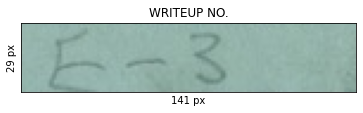

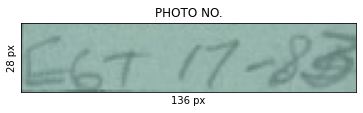

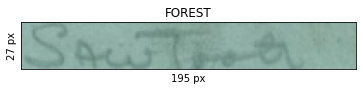

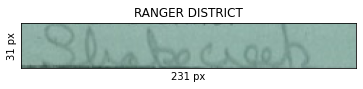

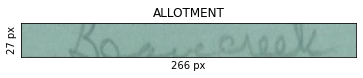

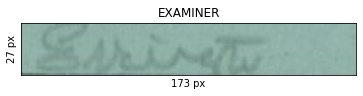

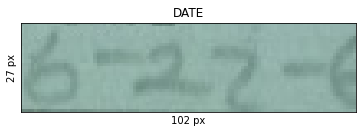

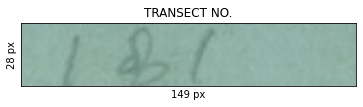

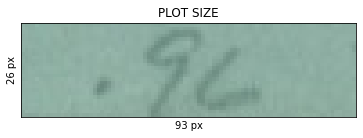

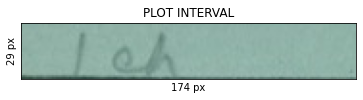

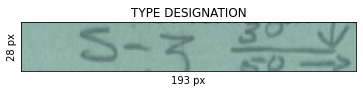

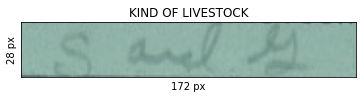

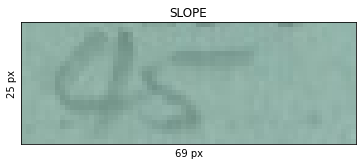

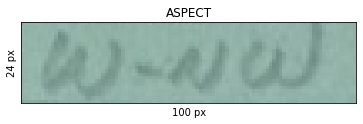

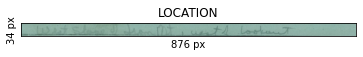

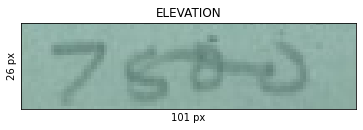

In [4]:
fields = grab_fields_coords("all_fields.json")['fields']
form = cv2.imread("highRes_ForestService.jpg")
fields = grab_fields()
field = fields[list(fields)[len(list(fields))-2]]
for field_name, crop_img in fields.items():
    show_image(crop_img, name=field_name)

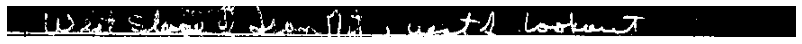

In [5]:
bw_image = bw(field)
show_image_true_size(bw_image)

In [6]:
# https://developpaper.com/python-implementation-of-image-vertical-projection-example/
# https://arxiv.org/pdf/2103.08922v1.pdf
# http://www.cvc.uab.es/icdar2009/papers/3725a651.pdf
# file:///home/jsv/Downloads/amc27114.pdf

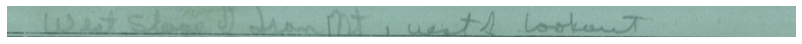

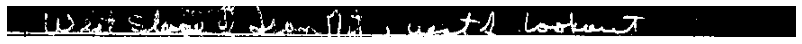

In [7]:
show_image_true_size(field)
show_image_true_size(bw_image)

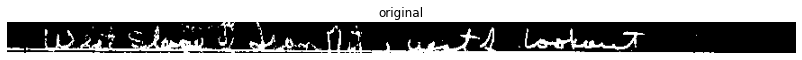

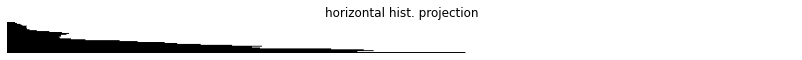

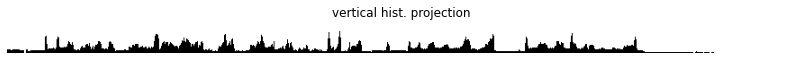

In [8]:
def create_h_v_projections(image, show=False):
    h_projection = image.copy()
    v_projection = image.copy()
    
    # Vertical projection
    (h, w) = h_projection.shape
    a = [0 for _ in range(w)]

    for x in range(w):
        for y in range(h):
            if v_projection[y, x] == 255:
                a[x] += 1
                v_projection[y, x] = 0

    for x in range(w):
        for y in range(h - a[x]):
            v_projection[y, x] = 255

    # Horizontal projection
    (h, w) = h_projection.shape
    b = [0 for _ in range(h)]

    for y in range(h):
        for x in range(w):
            if h_projection[y, x] == 255:
                b[y] += 1
                h_projection[y, x] = 0

    for y in range(h):
        for x in range(b[y], w):
            h_projection[y, x] = 255

    if show:
        show_image(image, name="original", true_size=True)
        show_image(h_projection, name="horizontal hist. projection", true_size=True)
        show_image(v_projection, name="vertical hist. projection", true_size=True)
    
    return h_projection, v_projection

h_proj, v_proj = create_h_v_projections(bw_image, show=True)

- #### What happens if we perform a gaussian blurring before the thresholding?

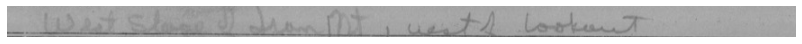

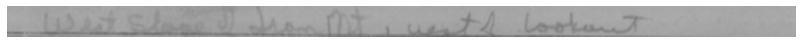

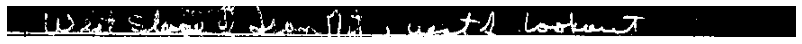

In [9]:
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
show_image(gray_img, true_size=True)
gauss_img = cv2.GaussianBlur(gray_img, (3,3), 2)
show_image(gauss_img, true_size=True)
(thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
show_image(thresh_img, true_size=True)
h_proj, v_proj = create_h_v_projections(thresh_img)
# We can see that it remains practically the same...

- #### What if we first remove long horizontal and vertical lines? (form lines appearing in the image as a result of the cropping)

Algorithm II.1 from this paper [https://arxiv.org/pdf/2103.08922v1.pdf]

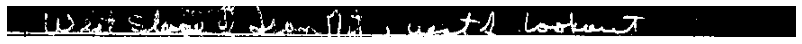

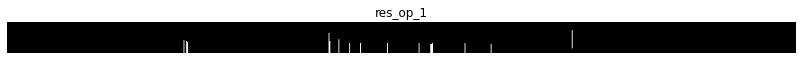

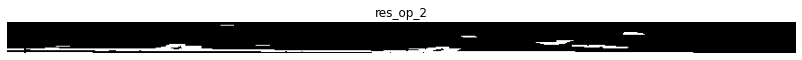

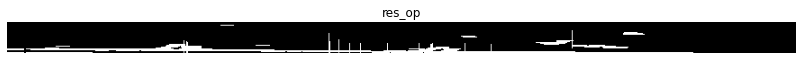

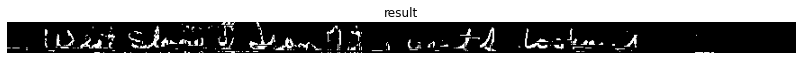

In [10]:
# Start with the thresholded image
#field = fields['PLOT INTERVAL']
field = fields['LOCATION']
bw_img = bw(field)
show_image(bw_img, true_size=True)
"""
 [INFO] 
  https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
 
 [TERMS]
  opening operation => erosion followed by dilation
  erosion => we can think of it as noise removal
  dilation => we can think of it as make the foreground more prominent
  
 Steps:
  1. black image | opening | structuring element E (w=1, h=param1) -> res_op_1
  2. black image | opening | structuring element E (w=param1, h=1) -> res_op_2
  3. res_op_1 + res_op_2 -> res_op
  4. black_image - res_op -> result
"""
# Step 1
param_1 = 4
kernel = np.ones((5,5),np.uint8)
res_op_1 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
show_image(res_op_1, "res_op_1", true_size=True)
# Step 2
res_op_2 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((1, 15), np.uint8))
show_image(res_op_2, "res_op_2", true_size=True)
# Step 3
res_op = res_op_1 + res_op_2
show_image(res_op, "res_op", true_size=True)
# Step 4
line_1_result = bw_img - res_op
show_image(line_1_result, "result", true_size=True)

def remove_long_h_v_lines(bw_img, show=False):
    param_1 = 4
    kernel = np.ones((5,5),np.uint8)
    res_op_1 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
    # Step 2
    res_op_2 = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, np.ones((1, 15), np.uint8))
    # Step 3
    res_op = res_op_1 + res_op_2
    # Step 4
    line_1_result = bw_img - res_op
    if show: 
        show_image(line_1_result, "horizontal and vertical lines cleaned")
    
    return line_1_result

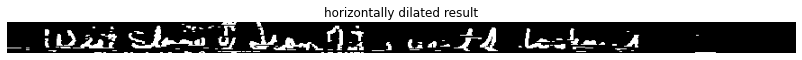

In [11]:
# Now perform horizontal dilation on the result
kernel = np.ones((1, 2), np.uint8)
h_dil_res = cv2.dilate(line_1_result, kernel,iterations=2)
show_image(h_dil_res, "horizontally dilated result", true_size=True)

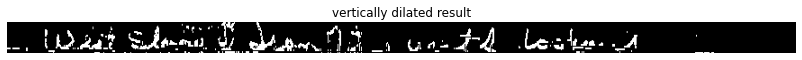

In [12]:
# Perform vertical dilation on the result
kernel = np.ones((2, 1), np.uint8)
v_dil_res = cv2.dilate(line_1_result, kernel,iterations=1)
show_image(v_dil_res, "vertically dilated result", true_size=True)

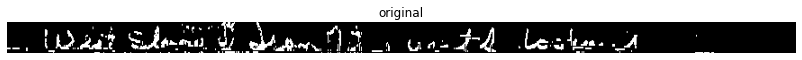

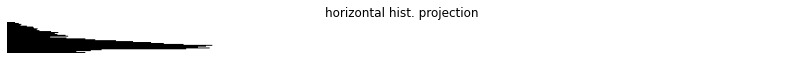

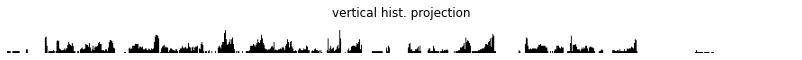

In [13]:
# Lets see the image projections
h_proj, v_proj = create_h_v_projections(v_dil_res, show=True)

**Conclusion:** We can see that the horizontal histogram projection now presents more gaps in it. 

Would that help determine a sliding window horizontal length based on that information? Let's continue with the steps in the algorithm II.1 [https://arxiv.org/pdf/2103.08922v1.pdf%5D]

We've previously performed the second line of the algorithm, which objective was removing long horizontal and vertical lines. Now we're going to implement third line of the same algorithm to try to concatenate pieces of characters horizontally.

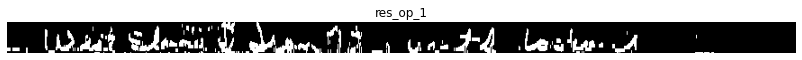

In [14]:
 """
 Steps:
  1. line_1_result | dilation | structuring element E (w=param2, 1) -> res_op_1
  2. res_op_1 | inverse -> line_2_result
"""
res_op_1 = cv2.dilate(line_1_result, (5, 1), iterations=3)
show_image(res_op_1, name="res_op_1", true_size=True)

In [15]:
h_proj, v_proj = create_h_v_projections(res_op_1)

Still don't know how to merge this with information with the sliding window... Try a different approach

The sliding window has two parameters that can be tweaked. The window size and the step.

- How could we better adjust the window size by looking at the horizontal histogram projection?
- How could we better adjust the step parameter by looking at the same information?

[file:///home/jsv/Downloads/TSP_CMC_28373.pdf]

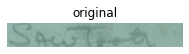

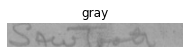

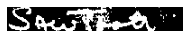

(195,)

In [16]:
# Vertical projection - Section 4.1
field = fields['FOREST']
show_image(field, name="original", true_size=True)
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
show_image(gray_img, name="gray", true_size=True)
(thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
show_image(thresh_img, true_size=True)

vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
vertical_projection_hist.shape

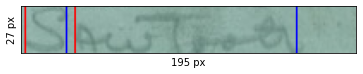

In [17]:
# Segmentate field into words - Section 4.2
def seg_field_words(v_proj_hist, px_freq_thresh=2):
    words = []
    start = None
    end = None
    recording = False
    for idx, freq in enumerate(v_proj_hist):

        if not recording:
            if freq > px_freq_thresh:
                recording = True
                start = idx
            else:
                continue
        else:
            if freq > px_freq_thresh:
                continue
            else:
                end = idx - 1
                recording = False
                if (end - start) >= 5:
                    words.append((start, end))
        
    # If recording is true but we hit the end of the for loop without setting the end
    if recording:
        end = idx
        words.append((start, end))
            
    return words


words = seg_field_words(vertical_projection_hist)
segmented = field.copy()     
for word in words:
    start, end = word
    segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
    segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
show_image(segmented)

In [18]:
# Segmentation points extraction algorithm - Section 4.3
def segmentation_points(v_projection, block_size, step_size, thresh):
    seg = []
    sumC = 0 # Sum of current block values
    sumP = 0 # Sum of preceding block values
    i = step_size
    j = 0
    k = 0
    
    while k <= block_size:
        sumP += v_projection[k]
        k += 1
    
    while i < (v_projection.shape[0] - block_size):
        
        k = i
        while k <= (i + block_size):
            sumC += v_projection[k]
            k += 1
        
        if (sumP - sumC) > thresh:
            seg.insert(j, i + (block_size / 2)) # Keep the index of the segmentation
            j += 1
            sumP = 0
        else:
            sumP = sumC
            
        i += step_size
        sumC = 0
    
    return seg
    
seg_points = segmentation_points(vertical_projection_hist, 9, 5, 3)

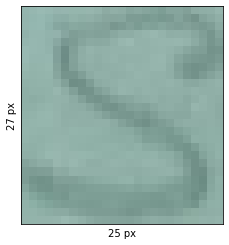

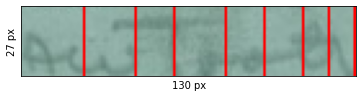

In [19]:
for word in words:
    start, end = word
    word_v_hist_proj = vertical_projection_hist[start:end + 1]
    word_seg_p = segmentation_points(word_v_hist_proj, 6, 5, 55)
    
    segmented = field.copy()[:, start:end+1]
    if word_seg_p:
        for seg_p in seg_points:
            segmented = cv2.line(segmented, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
    show_image(segmented)

Field name: WRITEUP NO.


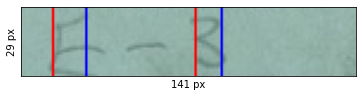

Field name: PHOTO NO.


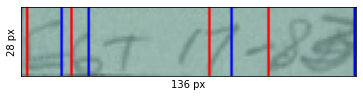

[]


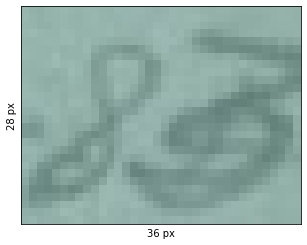

###
Field name: FOREST


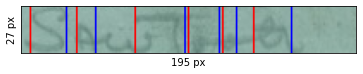

[]


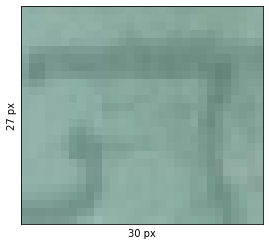

###
Field name: RANGER DISTRICT


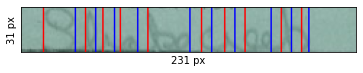

[]


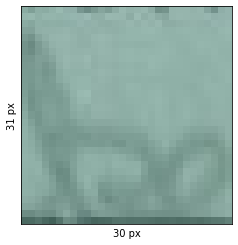

###
Field name: ALLOTMENT


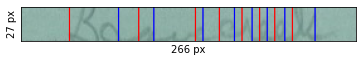

[22.5]


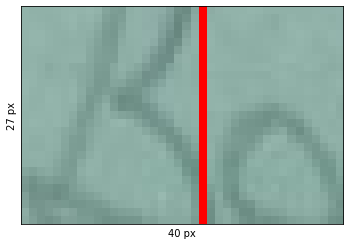

###
Field name: EXAMINER


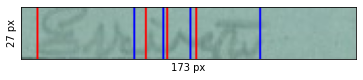

[17.5, 27.5, 37.5]


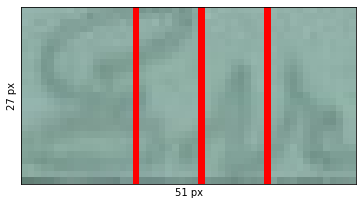

###
[]


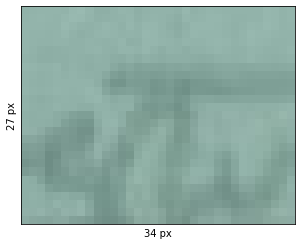

###
Field name: DATE


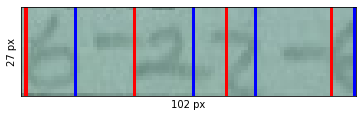

Field name: TRANSECT NO.


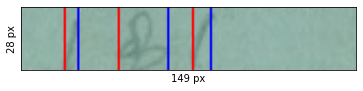

Field name: PLOT SIZE


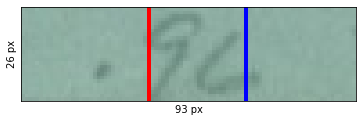

[]


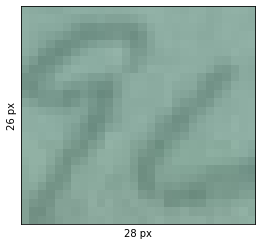

###
Field name: PLOT INTERVAL


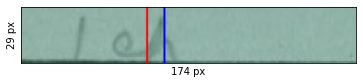

Field name: TYPE DESIGNATION


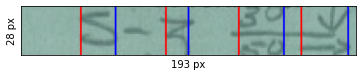

[]


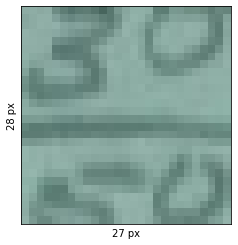

###
[]


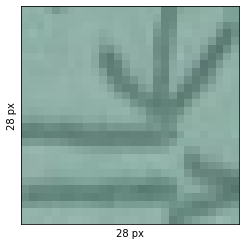

###
Field name: KIND OF LIVESTOCK


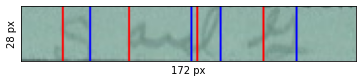

[]


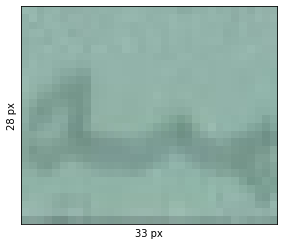

###
Field name: SLOPE


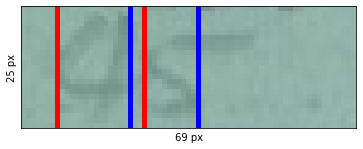

Field name: ASPECT


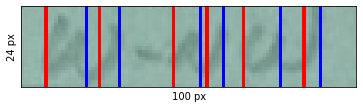

Field name: LOCATION


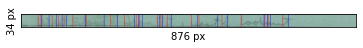

[]


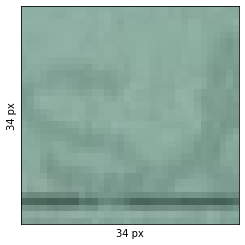

###
[]


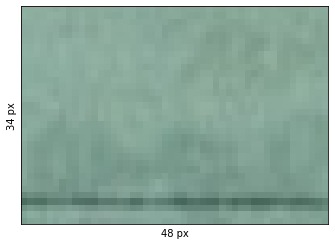

###
[]


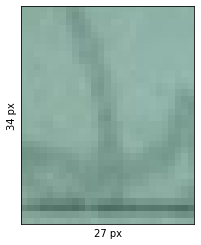

###
[17.5]


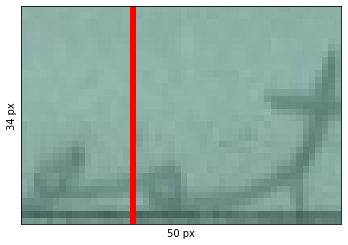

###
[17.5, 32.5]


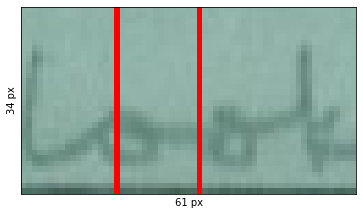

###
Field name: ELEVATION


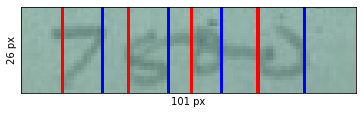

In [20]:
for field in fields:
    print(f"Field name: {field}")
    field = fields[field]
    # Get vertical projection
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist, 4)
    segmented = field.copy()     
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    show_image(segmented)
    # Segment words into characters
    for word in words:
        start, end = word
        word_v_hist_proj = vertical_projection_hist[start:end + 1]
        block_size = 25
        if len(word_v_hist_proj) > block_size:
            word_seg_p = segmentation_points(word_v_hist_proj, block_size, 5, 8)
            print(word_seg_p)
            seg = field.copy()[:, start:end+1]
            if word_seg_p:
                for seg_p in word_seg_p:
                    seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
            show_image(seg)
            print("###")
    

vert_hist: 136 [19.  2. 17. 17.  9.  9.  8.  8.  8.  8.  8.  8.  9.  9.  9.  8.  6.  3.
  2.  2.  7. 11. 10. 10.  9.  8.  7.  5.  4.  4.  6.  7.  5.  2.  3.  4.
  3.  3.  4.  4.  4. 11. 12.  9.  6.  4.  2.  2.  2.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  5.  6.  5.  5.  4.  4.  3.
  2.  0.  0.  1.  7.  8.  6.  6.  5.  6.  6.  5.  6.  6.  4.  3.  2.  0.
  0.  2.  3.  3.  3.  3.  3.  2.  3.  2.  5.  8.  9.  7.  7.  6.  7.  7.
  8. 12. 17. 11.  5.  6.  9. 10. 11. 10.  7. 10. 11. 14. 14. 16. 16. 15.
 15. 13. 16. 17. 16. 18. 17. 16. 14.  7.]
words=> [(2, 17), (20, 32), (34, 45), (64, 71), (76, 87), (100, 135)]


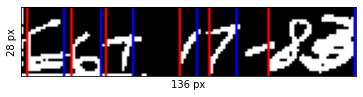

'\nIt was a bug on the seg_field_words function. We exited the for loop while a recording was in progress \n'

In [21]:
# Why seg_field_words function doesn't find the characters "-83" of the field PHOTO NO.
field = fields['PHOTO NO.']
# Get vertical projection
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
(thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
print("vert_hist:", len(vertical_projection_hist), vertical_projection_hist)
# Segment it to words
words = seg_field_words(vertical_projection_hist)
segmented = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
print("words=>", words)
for word in words:
    start, end = word
    segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
    segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
show_image(segmented)
"""
It was a bug on the seg_field_words function. We exited the for loop while a recording was in progress 
"""

We can see that in some cases the slicing of characters is pretty good and we could take the length of those points to be our slicing window size.

Could results be improved if we first clean the image?

Field name: WRITEUP NO.


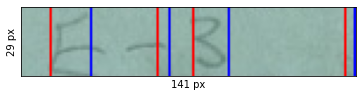

[10.0] 18


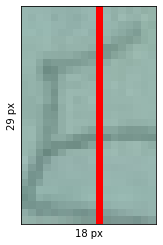

###
[] 16


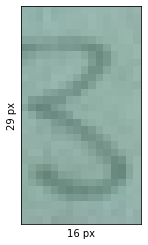

###
Field name: PHOTO NO.


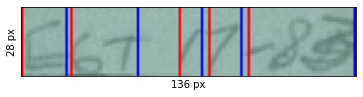

[10.0] 19


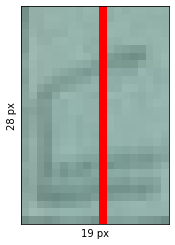

###
[10.0] 28


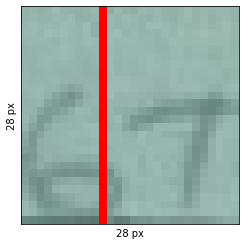

###
[] 14


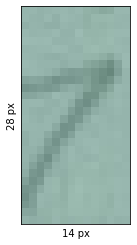

###
[25.0, 35.0] 44


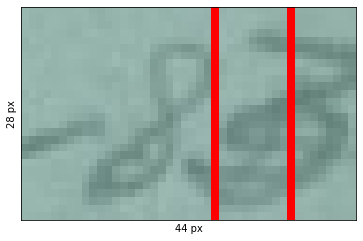

###
Field name: FOREST


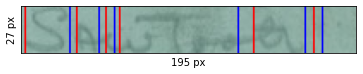

[] 27


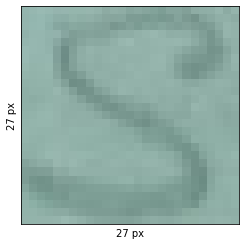

###
[] 14


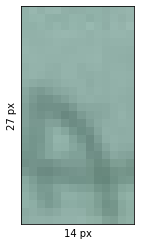

###
[40.0, 55.0] 70


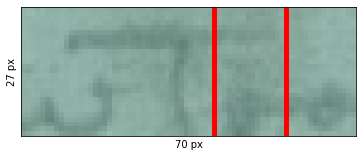

###
[15.0, 25.0] 31


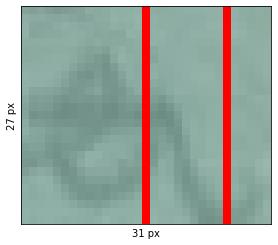

###
Field name: RANGER DISTRICT


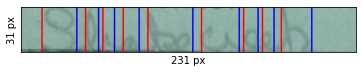

[] 25


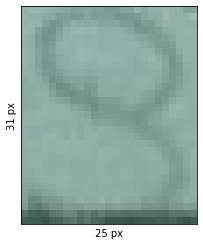

###
[] 12


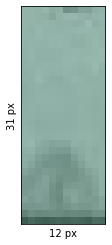

###
[10.0] 32


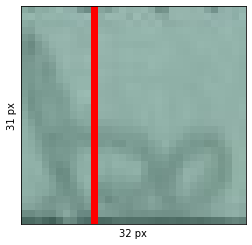

###
[10.0] 27


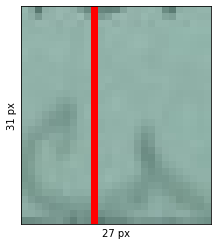

###
[] 11


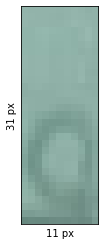

###
[10.0] 22


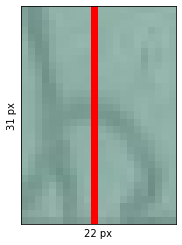

###
Field name: ALLOTMENT


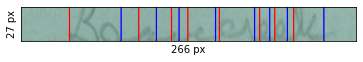

[20.0, 30.0] 42


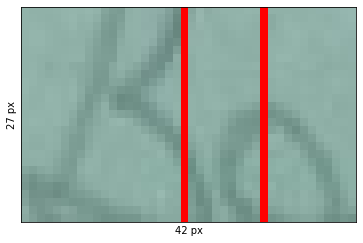

###
[] 15


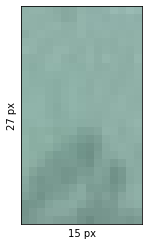

###
[15.0] 23


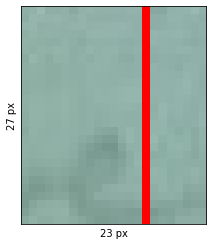

###
[10.0] 29


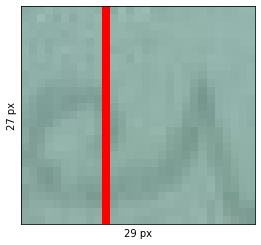

###
[] 11


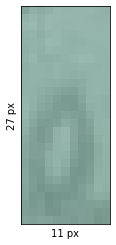

###
[15.0] 25


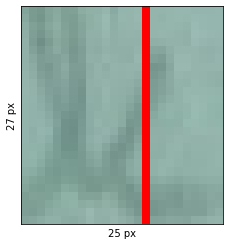

###
Field name: EXAMINER


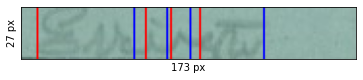

[15.0, 25.0, 45.0] 51


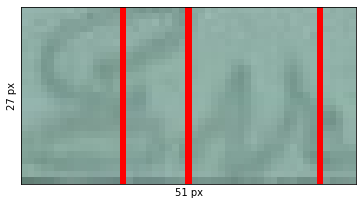

###
[] 12


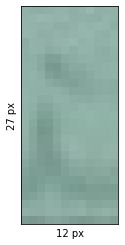

###
[] 11


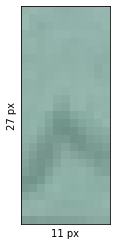

###
[20.0] 34


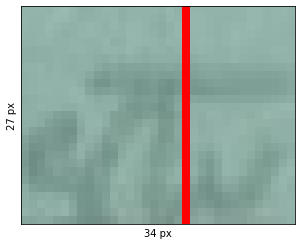

###
Field name: DATE


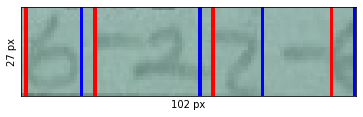

[10.0] 18


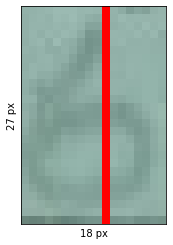

###
[] 33


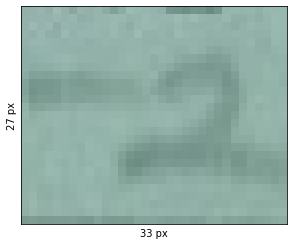

###
[] 16


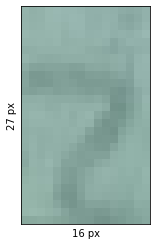

###
Field name: TRANSECT NO.


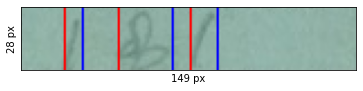

[15.0] 25


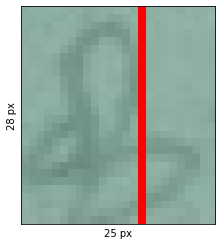

###
[] 13


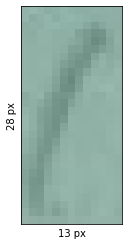

###
Field name: PLOT SIZE


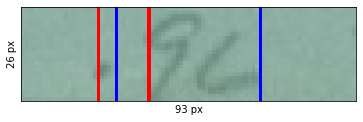

[15.0, 25.0] 32


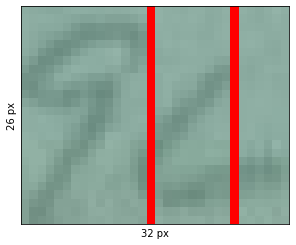

###
Field name: PLOT INTERVAL


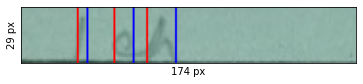

[] 11


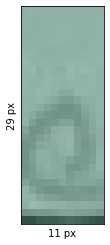

###
[10.0] 16


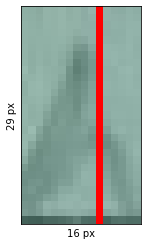

###
Field name: TYPE DESIGNATION


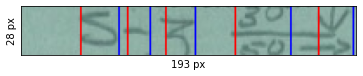

[15.0] 23


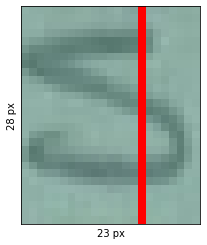

###
[] 14


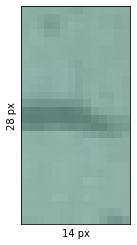

###
[] 18


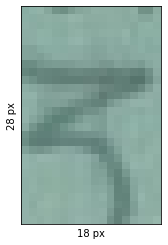

###
[15.0] 33


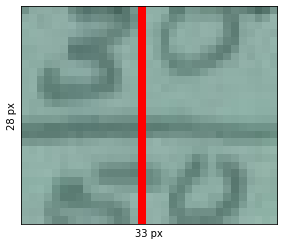

###
[15.0] 21


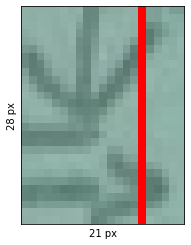

###
Field name: KIND OF LIVESTOCK


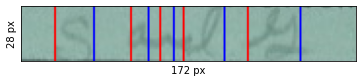

[] 21


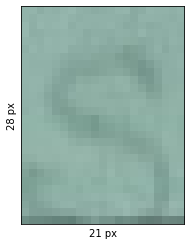

###
[] 22


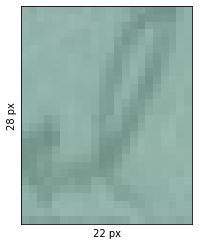

###
[20.0] 28


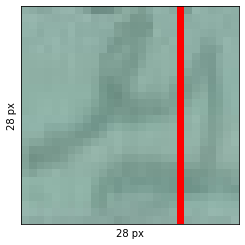

###
Field name: SLOPE


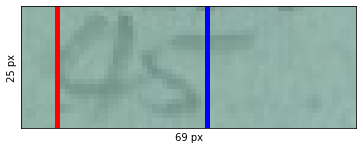

[15.0, 25.0] 32


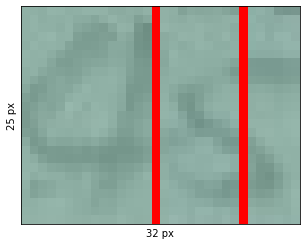

###
Field name: ASPECT


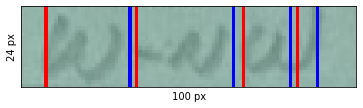

[10.0, 20.0] 26


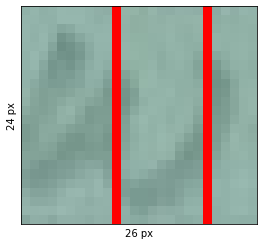

###
[] 30


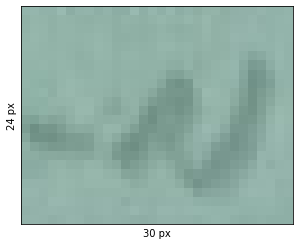

###
[] 15


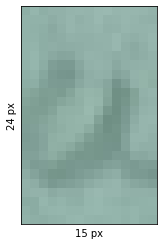

###
Field name: LOCATION


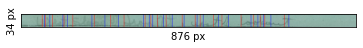

[] 13


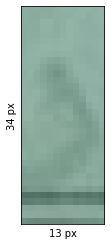

###
[15.0] 28


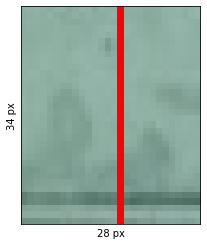

###
[15.0, 35.0, 45.0] 51


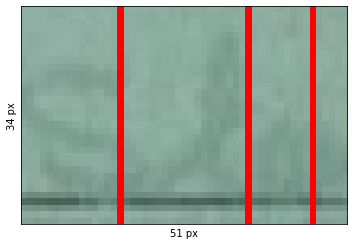

###
[15.0] 29


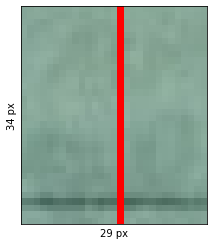

###
[15.0] 21


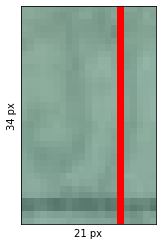

###
[15.0, 35.0] 52


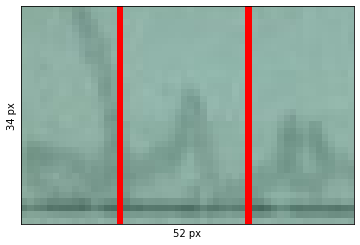

###
[] 12


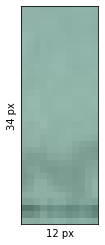

###
[] 17


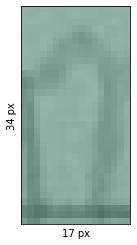

###
[] 17


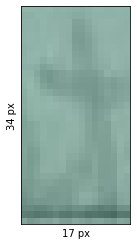

###
[] 14


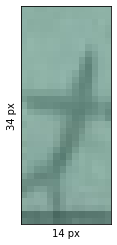

###
[] 18


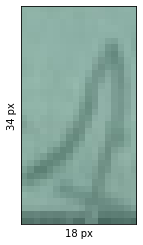

###
[10.0] 27


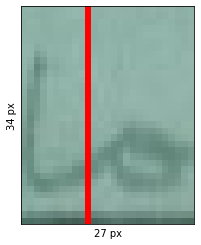

###
[] 12


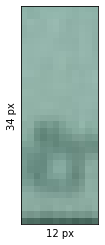

###
[] 17


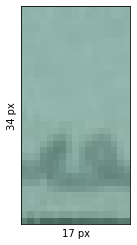

###
[] 13


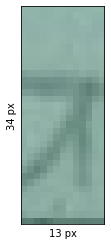

###
Field name: ELEVATION


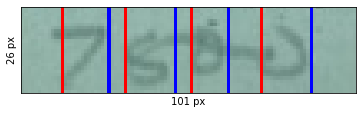

[] 15


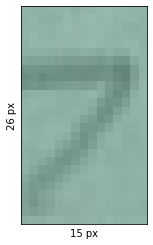

###
[10.0] 16


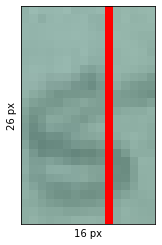

###
[] 12


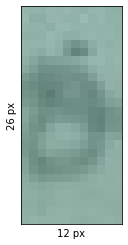

###
[] 16


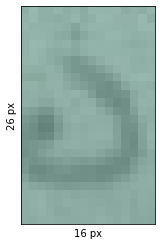

###


In [22]:
for field in fields:
    print(f"Field name: {field}")
    field = fields[field]
    # Threshold image
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Clean image
    thresh_img = remove_long_h_v_lines(thresh_img)
    # Horizontal dilation
    thresh_img = cv2.dilate(thresh_img, np.ones((1, 2), np.uint8), iterations=2)
    # Get vertical projection
    vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist)
    segmented = field.copy()     
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    show_image(segmented)
    # Segment words into characters
    for word in words:
        start, end = word
        word_v_hist_proj = vertical_projection_hist[start:end + 1]
        block_size = 10
        if len(word_v_hist_proj) > block_size:
            word_seg_p = segmentation_points(word_v_hist_proj, block_size, 5, 3)
            seg = field.copy()[:, start:end+1]
            print(word_seg_p, len(word_v_hist_proj))
            if word_seg_p:
                for seg_p in word_seg_p:
                    seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
            show_image(seg)
            print("###")
    

We see that in the cleaned version the field named "RANGER DISTRICT" is poorly segmentated and the character slicing performs much better when we actually run it through the whole word. 

That makes me think that the character slicer step works better with full words. We should try to connect the words.

Field name: WRITEUP NO.


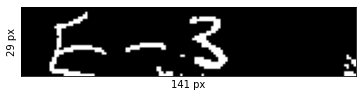

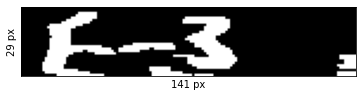

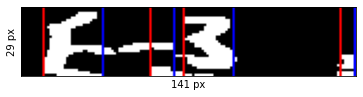

[15.0] 26


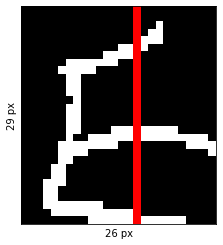

###
[] 11


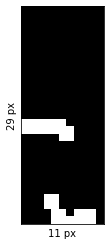

###
[15.0] 22


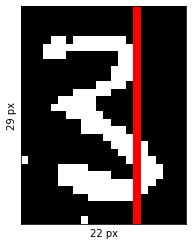

###
Field name: PHOTO NO.


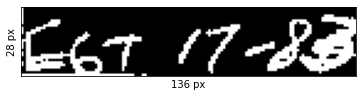

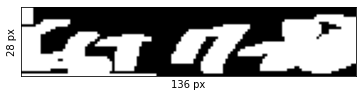

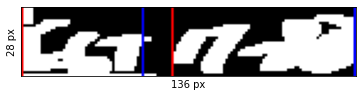

[10.0, 30.0] 50


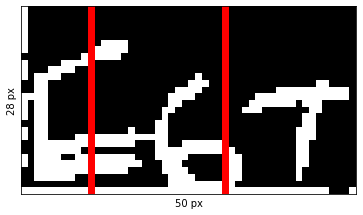

###
[25.0] 75


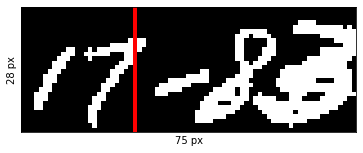

###
Field name: FOREST


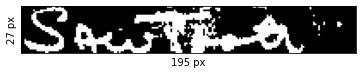

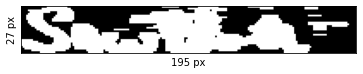

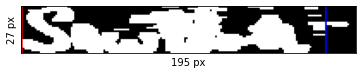

[25.0, 40.0, 50.0, 60.0, 95.0, 110.0, 120.0, 130.0, 150.0, 160.0, 170.0] 178


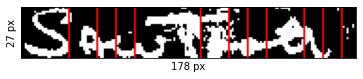

###
Field name: RANGER DISTRICT


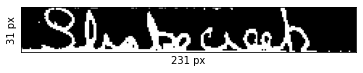

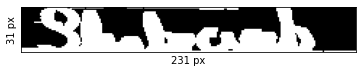

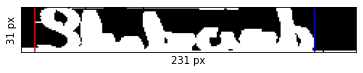

[30.0, 45.0, 55.0, 70.0, 90.0, 105.0, 125.0, 140.0, 160.0, 180.0] 194


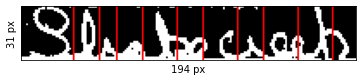

###
Field name: ALLOTMENT


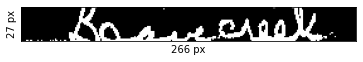

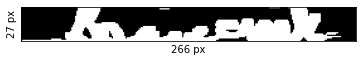

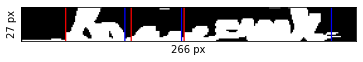

[20.0, 30.0, 40.0] 48


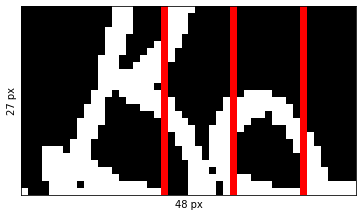

###
[15.0, 25.0] 41


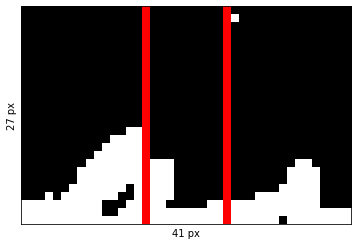

###
[15.0, 40.0, 55.0, 70.0, 80.0, 100.0, 110.0] 118


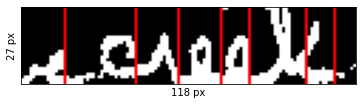

###
Field name: EXAMINER


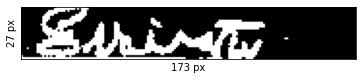

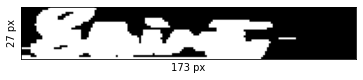

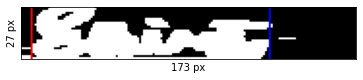

[20.0, 30.0, 45.0, 55.0, 70.0, 80.0, 110.0] 124


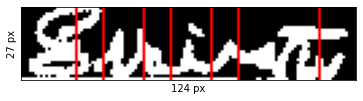

###
Field name: DATE


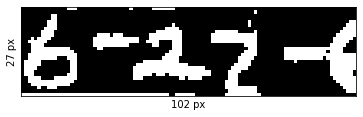

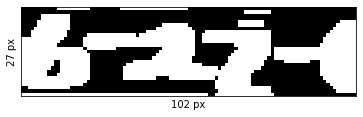

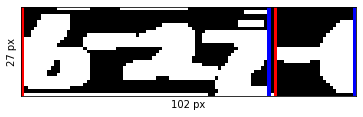

[15.0, 50.0, 70.0] 76


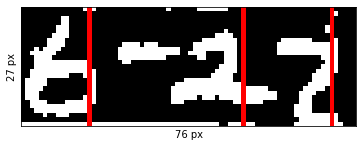

###
[] 25


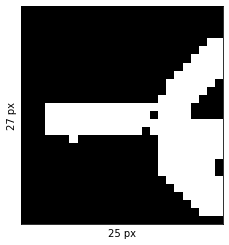

###
Field name: TRANSECT NO.


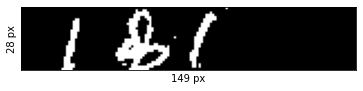

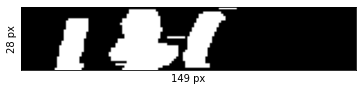

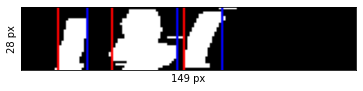

[] 14


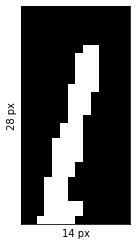

###
[15.0] 30


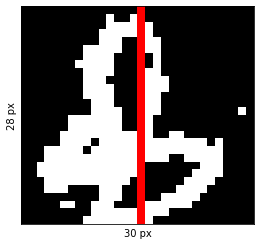

###
[] 18


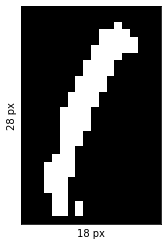

###
Field name: PLOT SIZE


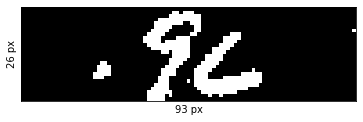

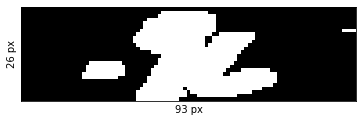

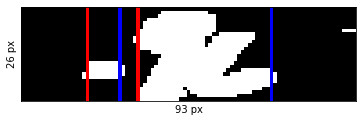

[15.0, 25.0] 38


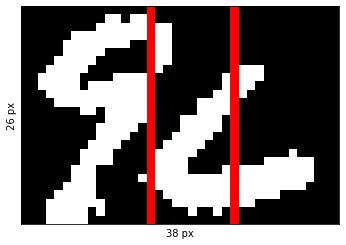

###
Field name: PLOT INTERVAL


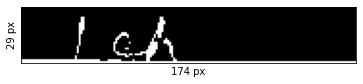

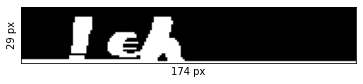

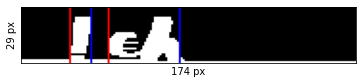

[] 12


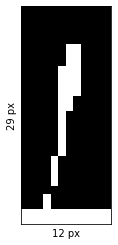

###
[10.0, 30.0] 38


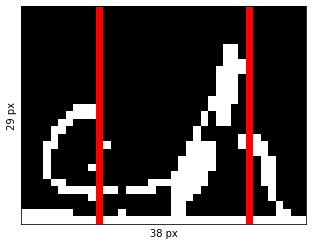

###
Field name: TYPE DESIGNATION


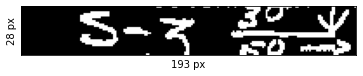

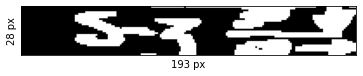

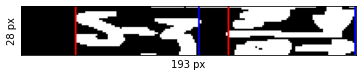

[15.0, 25.0, 40.0, 65.0] 72


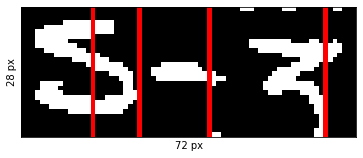

###
[20.0, 30.0, 40.0, 65.0] 74


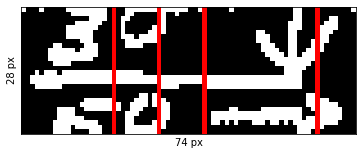

###
Field name: KIND OF LIVESTOCK


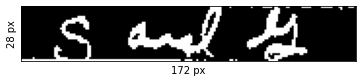

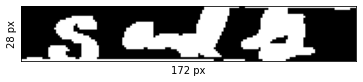

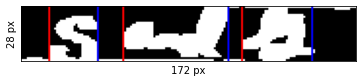

[20.0] 26


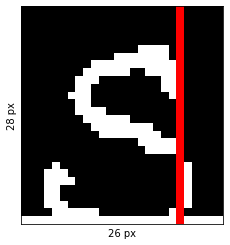

###
[15.0, 35.0] 55


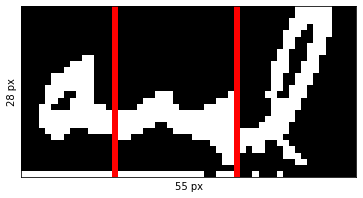

###
[25.0] 37


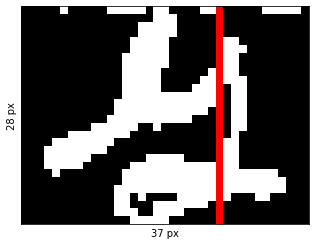

###
Field name: SLOPE


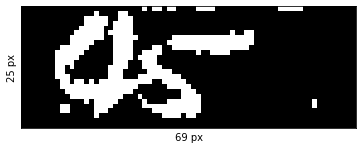

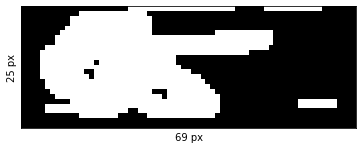

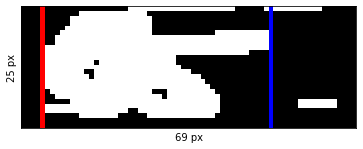

[20.0, 30.0, 40.0] 48


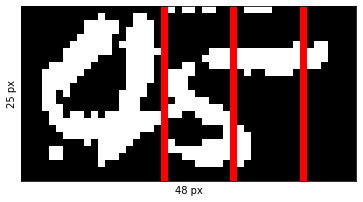

###
Field name: ASPECT


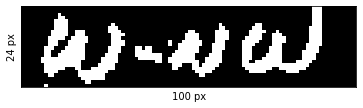

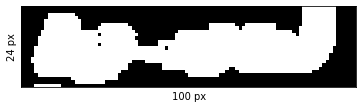

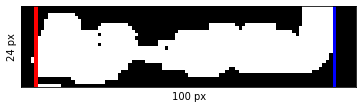

[15.0, 25.0, 55.0, 75.0] 90


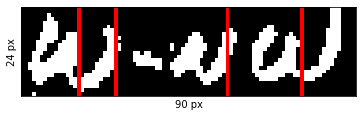

###
Field name: LOCATION


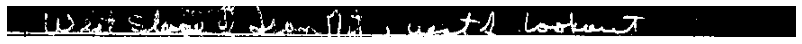

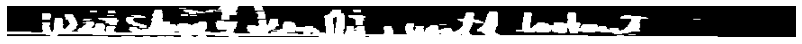

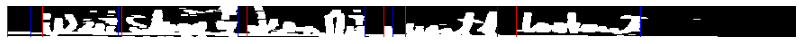

[15.0] 27


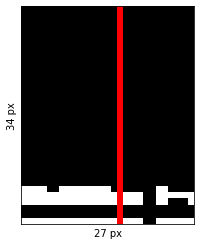

###
[10.0, 25.0, 35.0, 65.0] 85


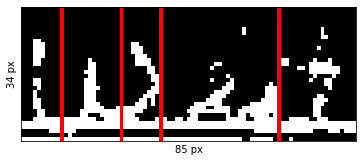

###
[25.0, 45.0, 55.0, 75.0, 90.0, 100.0] 130


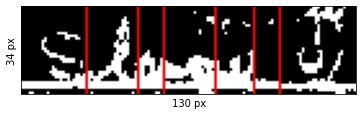

###
[20.0, 30.0, 50.0, 75.0, 105.0, 125.0] 132


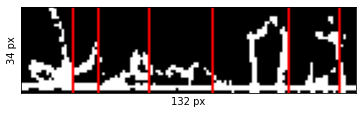

###
[] 11


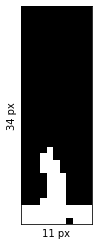

###
[20.0, 35.0, 50.0, 75.0] 103


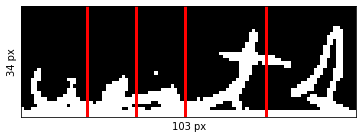

###
[20.0, 35.0, 55.0, 70.0, 85.0, 95.0] 139


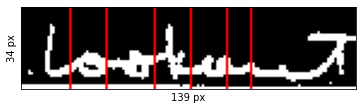

###
Field name: ELEVATION


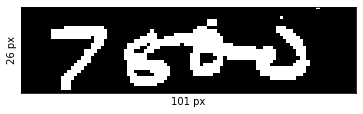

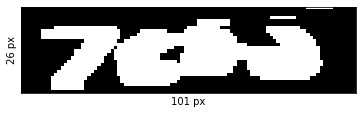

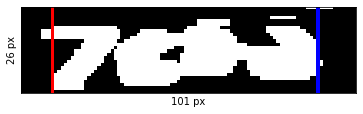

[15.0, 35.0, 50.0, 75.0] 81


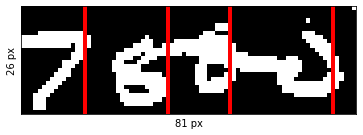

###


In [23]:
segs_approach_2 = {}
for field in fields:
    field_name = field
    print(f"Field name: {field_name}")
    field_name = field
    field = fields[field]
    # Threshold image
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if field_name == "LOCATION":
        show_image(thresh_img, true_size=True)
    else:
        show_image(thresh_img)
    # Horizontal dilation
    kernel = np.ones((1, 8), np.uint8)
    h_dil_img = cv2.dilate(thresh_img, kernel, iterations=1)
    # Vertical dilation
    kernel = np.ones((3, 1), np.uint8)
    v_dil_img = cv2.dilate(h_dil_img, kernel, iterations=2)
    if field_name == "LOCATION":
        show_image(h_dil_img, true_size=True)
    else:
        show_image(h_dil_img)
    # Get vertical projection
    vertical_projection_hist = np.sum(h_dil_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist, 3)
    segmented = cv2.cvtColor(h_dil_img, cv2.COLOR_GRAY2BGR)
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    if field_name == "LOCATION":
        show_image(segmented, true_size=True)
    else:
        show_image(segmented)
    # Segment words into characters
    for word in words:
        start, end = word
        # It uses for that the vertical projection histogram of the thresholded image
        word_v_hist_proj = np.sum(thresh_img / 255, axis=0)[start:end + 1]
        block_size = 10
        if len(word_v_hist_proj) > block_size:
            word_seg_p = segmentation_points(word_v_hist_proj, block_size, 5, 5)
            seg = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)[:, start:end+1]
            seg_orig = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
            print(word_seg_p, len(word_v_hist_proj))
            if word_seg_p:
                # Calculate the segmentation points in respect of the original image
                seg_ps_original = [seg_p + start for seg_p in word_seg_p]
                seg_ps_saved = segs_approach_2.get(field_name, [])
                segs_approach_2[field_name] = seg_ps_saved + seg_ps_original
                for seg_p in word_seg_p:
                    #seg_p_orig = seg_p + start
                    seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
                    #seg_orig = cv2.line(seg_orig, (int(seg_p_orig), 0), (int(seg_p_orig), field.shape[0]), (0, 0, 255), 1)
            else:
                seg_ps_saved = segs_approach_2.get(field_name, [])
                segs_approach_2[field_name] = seg_ps_saved + [start, end]
                
            show_image(seg)
            #show_image(seg_orig)
            print("###")

**Dr. Cathie Idea:** Turn 45º counter clock-wise words that have characters that are contiguous to each other.

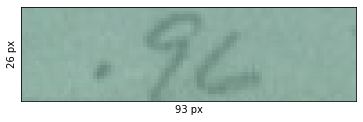

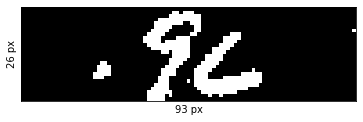

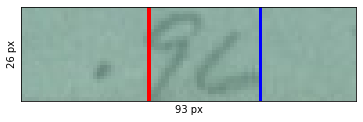

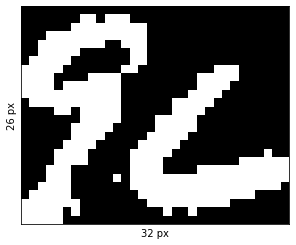

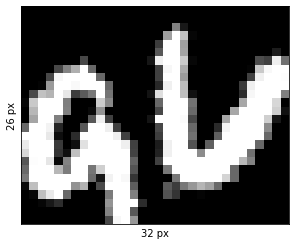

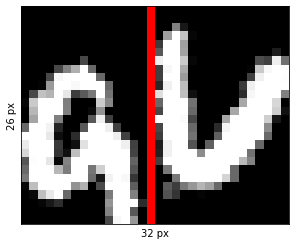

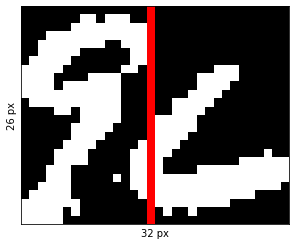

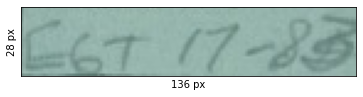

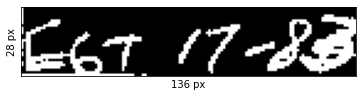

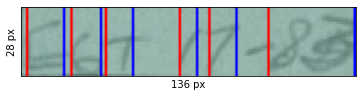

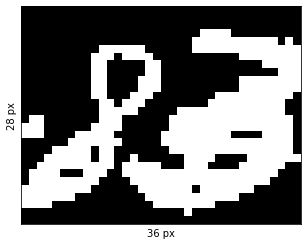

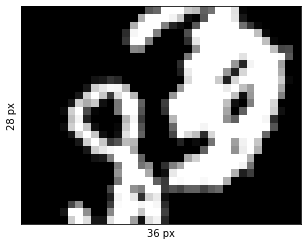

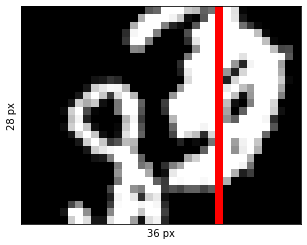

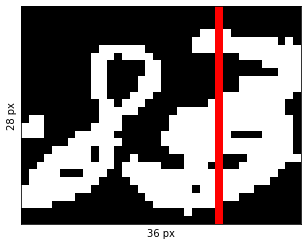

In [24]:
def rotate(field, selected_word):
    
    show_image(field)
    # Threshold image
    gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
    (thresh, thresh_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    show_image(thresh_img)
    # Get vertical projection
    vertical_projection_hist = np.sum(thresh_img / 255, axis=0)
    # Segment it to words
    words = seg_field_words(vertical_projection_hist)
    segmented = field.copy()     
    for word in words:
        start, end = word
        segmented = cv2.line(segmented, (start, 0), (start, field.shape[0]), (0, 0, 255), 1)
        segmented = cv2.line(segmented, (end, 0), (end, field.shape[0]), (255, 0, 0), 1)
    show_image(segmented)

    word = words[selected_word]
    start, end = word
    # Rotate word of interest (the 96)
    word_sel = thresh_img[:, start:end+1]
    show_image(word_sel)
    (h, w) = word_sel.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    rotated = cv2.warpAffine(word_sel, M, (w, h))
    show_image(rotated)
    # Perform histogram on the rotated image
    word_v_hist_proj = np.sum(rotated / 255, axis=0)
    #word_v_hist_proj = vertical_projection_hist[start:end + 1]
    word_seg_p = segmentation_points(word_v_hist_proj, block_size=20, step_size=5, thresh=5)
    seg_rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
    seg = cv2.cvtColor(word_sel, cv2.COLOR_GRAY2BGR)
    if word_seg_p:
        for seg_p in word_seg_p:
            seg = cv2.line(seg, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)
            seg_rotated = cv2.line(seg_rotated, (int(seg_p), 0), (int(seg_p), field.shape[0]), (0, 0, 255), 1)

    show_image(seg_rotated)
    show_image(seg)

rotate(fields['PLOT SIZE'], 0)
rotate(fields['PHOTO NO.'], 5)

### Comparison

In [25]:
# Load Floriana's script and change how input is gathered and output

from PIL import Image
"""
Performs the image preprocessing on the field image 
before bounding boxes identification
"""
def img_preprocess(fields):
#     DIR = "fields/"

#     # this is the list where 
#     # each images data is stored 
#     list_of_dict = []

#     # if the output file has already been generated, 
#     # clean it out before appending to it
#     if os.path.exists("bbox_coord.json"):
#         file = open("bbox_coord.json","r+")
#         file.truncate(0)
#         file.close()
  
#     # counter = 0
#     #for each image in the output directory:
#     for image in os.listdir(DIR):
#         json_dict = {}
#         #set up the right string for the path 
#         path = DIR + image
        
#         # read in the image in gray scale
#         img = cv2.imread(path, 0) 
#         if img is None:
#             print(path)
#             exit(1)
    list_of_dict = []

    for field in fields:
        json_dict = {}
        img = fields[field]
        #perform the image preprocessing stepss
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(img, (3,3), cv2.BORDER_DEFAULT)
        ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        blurred = cv2.GaussianBlur(thresh, (3,3), cv2.BORDER_DEFAULT)
        con_img = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)
        dst = cv2.fastNlMeansDenoisingColored(con_img, None, 10, 10, 7, 21)
        
        json_data = find_char(dst, field, json_dict)
        list_of_dict.append(json_data)

    #create_json(list_of_dict)
    
    return list_of_dict
    
"""
Iterates through the image until it finds a character. 
It explores the character to find its max_x, min_x, max_y, min_y
@return dictionary of data to populate the json file
"""
def find_char(dst, img, json_dict):
     
    max_x, min_x, max_y, min_y = 0, 1000, 0, 1000
    json_list = []
    x = 0

    # Open the image using the PIL library
    im = Image.fromarray(dst)
    pixels = im.load()
    
    # clean the dictionary out 
    # before adding a new image
    json_dict.clear()

    #iterate through the pixels in dst
    while (x < im.size[0]): # for every pixel:
        y = 0
      
        while (y < im.size[1]):
          
            if pixels[x,y] != (0, 0, 0):
                
                max_x, min_x, max_y,  min_y = explore_active(x, y, im, pixels,  max_x, min_x, max_y, min_y)
              
                # if the area is big enough we identify it as a character
                if valid_area(max_x, max_y, min_x, min_y):
                    pixels[min_x, min_y] = (255, 0 , 0)
                    pixels[max_x, min_y] = (255, 0 , 0)
                    pixels[min_x, max_y] = (255, 0 , 0)
                    pixels[max_x, max_y] = (255, 0 , 0)

                    # counter = counter + 1
                    
                    json_list.append({'x': min_x, 
                                    'y': min_y, 
                                    'w': max_x-min_x,
                                    'h': max_y-min_y})
        
                y = 0

                x = max_x + 2
                if x > im.size[0]-1:
                    y = im.size[1]
                max_x, min_x, max_y, min_y = 0, 1000, 0, 1000
               

            else:
                y = y + 2
        
        x = x + 2
    
    #All the characters have been identified
  
    if valid_area(max_x, max_y, min_x, min_y):
        json_dict[img] = json_list
    
    return json_dict
"""
Accepts only the areas that are bigger than 100
@return boolean
"""
def valid_area(max_x, max_y, min_x, min_y):
    # calculate the area of the bbox to 
    # minimize noise
    width = max_x - min_x
    height = max_y - min_y
    area = width * height
    if area > 100:
        return True
    else:
        return False

 
"""
Creates the json file with the bbox coordinates
"""
def create_json(list_of_dict):
    
    # store the data into a new json file
    with open("bbox_coord.json", 'a') as outfile: 
        json.dump(list_of_dict, outfile)
    


"""
Checks the x axis boundary
@return boolean
"""    
def x_in_bound(x, im):
    if x >= 0 and x <= im.size[0]-1:
        return True
    else:
        return False

"""
Checks the y axis boundary
@return boolean
"""
def y_in_bound(y, im):
  
    if y >= 0 and y <= im.size[1]-1:
        return True
    else:
        return False


"""
Loops through all the pixels in the stack and colors them green when visited
@return min and max coordinates
"""
def explore_active(x, y, im, pixels,  max_x, min_x, max_y, min_y):
    # Initializing a values
    stack = []
    jump_size = 1
    stack.append((x,y))
    
    # while the stack holds tuples
    while len(stack) != 0:

        # pop the first pair off the stack
        pair = stack.pop(len(stack)-1)

        # if the pixel is already green, we have already visited it
        if x_in_bound(pair[0], im) and y_in_bound(pair[1], im) and pixels[pair[0], pair[1]] != (0, 255, 0):

            # check and update the bbox coordinates
            max_x, min_x, max_y, min_y = check_coord(pair[0], pair[1], max_x, min_x, max_y, min_y)

            # check to the right
            if look(pair[0]+jump_size, pair[1], im, pixels):
                stack.append((pair[0]+jump_size,pair[1]))

            # check down-wards
            if look(pair[0], pair[1]+jump_size, im, pixels):
                stack.append((pair[0],pair[1]+jump_size))

            # check to the left 
            if look(pair[0]-jump_size, pair[1], im, pixels):
                stack.append((pair[0]-jump_size,pair[1])) 

            # check up-wards
            if look(pair[0], pair[1]-jump_size, im, pixels):
                stack.append((pair[0],pair[1]-jump_size)) 
            
            #turn the pixel green to sign it as visited
            pixels[pair[0], pair[1]] = (0, 255, 0)

    
    return max_x, min_x, max_y,  min_y


"""
Looks if the neighbor pixels is available
"""
def look(x, y, im, pixels):

    retVal = False
    # check if x and y are in bound
    if x_in_bound(x, im) and y_in_bound(y, im):
        if pixels[x, y] != (0, 0, 0):
            retVal = True

    return retVal


"""
Updates the max and min coordinates
"""
def check_coord(x, y, max_x, min_x, max_y, min_y):
    if x > max_x:
        max_x = x
  
    if x < min_x:
        min_x = x
    
    if y > max_y:
        max_y = y
   
    if y < min_y:
        min_y = y

    return max_x, min_x, max_y,  min_y


In [26]:
segs_approach_1 = img_preprocess(fields)

def format_output(output):
    d = {}
    for seg in output:
        for el in seg.items():
            d[el[0]] = el[1]
    return d
segs_approach_1 = format_output(segs_approach_1)
segs_approach_1

{'WRITEUP NO.': [{'x': 10, 'y': 2, 'w': 25, 'h': 26},
  {'x': 43, 'y': 13, 'w': 19, 'h': 6},
  {'x': 70, 'y': 3, 'w': 17, 'h': 25}],
 'PHOTO NO.': [{'x': 0, 'y': 4, 'w': 34, 'h': 23},
  {'x': 33, 'y': 10, 'w': 16, 'h': 17},
  {'x': 63, 'y': 6, 'w': 26, 'h': 21},
  {'x': 90, 'y': 2, 'w': 45, 'h': 25}],
 'FOREST': [{'x': 1, 'y': 0, 'w': 26, 'h': 26},
  {'x': 30, 'y': 9, 'w': 49, 'h': 17},
  {'x': 65, 'y': 0, 'w': 99, 'h': 26}],
 'RANGER DISTRICT': [{'x': 0, 'y': 0, 'w': 200, 'h': 30}],
 'ALLOTMENT': [{'x': 36, 'y': 0, 'w': 207, 'h': 26}],
 'EXAMINER': [{'x': 0, 'y': 0, 'w': 126, 'h': 26}],
 'DATE': [{'x': 0, 'y': 1, 'w': 20, 'h': 25},
  {'x': 21, 'y': 4, 'w': 37, 'h': 18},
  {'x': 57, 'y': 6, 'w': 17, 'h': 20},
  {'x': 78, 'y': 2, 'w': 23, 'h': 24}],
 'TRANSECT NO.': [{'x': 17, 'y': 4, 'w': 10, 'h': 23},
  {'x': 41, 'y': 0, 'w': 26, 'h': 27},
  {'x': 74, 'y': 1, 'w': 13, 'h': 26}],
 'PLOT SIZE': [{'x': 33, 'y': 0, 'w': 34, 'h': 25}],
 'PLOT INTERVAL': [{'x': 0, 'y': 4, 'w': 157, 'h': 24}

In [27]:
segs_approach_2

{'WRITEUP NO.': [24.0, 54, 64, 83.0],
 'PHOTO NO.': [10.0, 30.0, 86.0],
 'FOREST': [25.0,
  40.0,
  50.0,
  60.0,
  95.0,
  110.0,
  120.0,
  130.0,
  150.0,
  160.0,
  170.0],
 'RANGER DISTRICT': [39.0,
  54.0,
  64.0,
  79.0,
  99.0,
  114.0,
  134.0,
  149.0,
  169.0,
  189.0],
 'ALLOTMENT': [55.0,
  65.0,
  75.0,
  102.0,
  112.0,
  144.0,
  169.0,
  184.0,
  199.0,
  209.0,
  229.0,
  239.0],
 'EXAMINER': [25.0, 35.0, 50.0, 60.0, 75.0, 85.0, 115.0],
 'DATE': [15.0, 50.0, 70.0, 77, 101],
 'TRANSECT NO.': [16, 29, 55.0, 72, 89],
 'PLOT SIZE': [47.0, 57.0],
 'PLOT INTERVAL': [25, 36, 55.0, 75.0],
 'TYPE DESIGNATION': [46.0, 56.0, 71.0, 96.0, 139.0, 149.0, 159.0, 184.0],
 'KIND OF LIVESTOCK': [34.0, 67.0, 87.0, 138.0],
 'SLOPE': [24.0, 34.0, 44.0],
 'ASPECT': [19.0, 29.0, 59.0, 79.0],
 'LOCATION': [15.0,
  49.0,
  64.0,
  74.0,
  104.0,
  152.0,
  172.0,
  182.0,
  202.0,
  217.0,
  227.0,
  286.0,
  296.0,
  316.0,
  341.0,
  371.0,
  391.0,
  418,
  428,
  462.0,
  477.0,
  492.0,
 

FIELD NAME: WRITEUP NO.


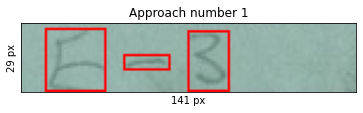

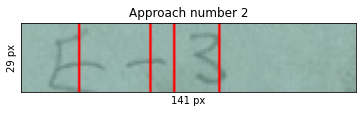

FIELD NAME: PHOTO NO.


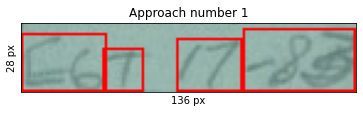

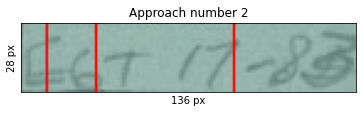

FIELD NAME: FOREST


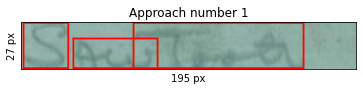

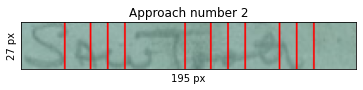

FIELD NAME: RANGER DISTRICT


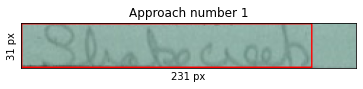

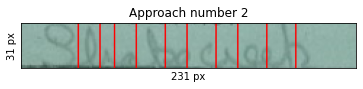

FIELD NAME: ALLOTMENT


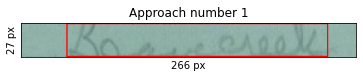

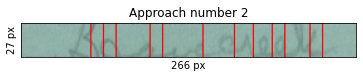

FIELD NAME: EXAMINER


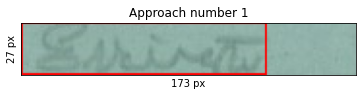

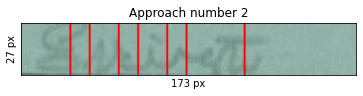

FIELD NAME: DATE


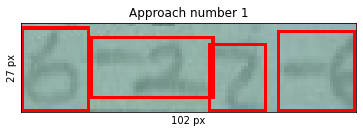

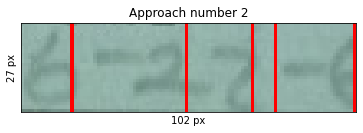

FIELD NAME: TRANSECT NO.


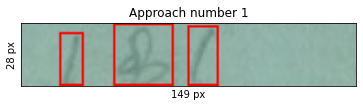

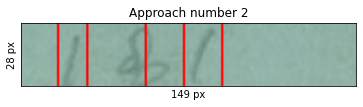

FIELD NAME: PLOT SIZE


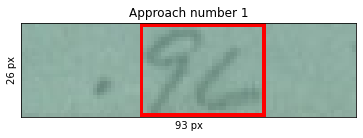

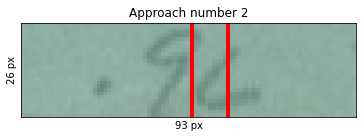

FIELD NAME: PLOT INTERVAL


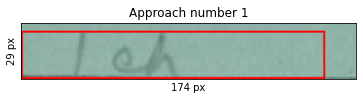

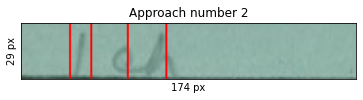

FIELD NAME: TYPE DESIGNATION


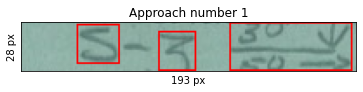

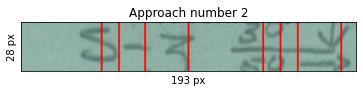

FIELD NAME: KIND OF LIVESTOCK


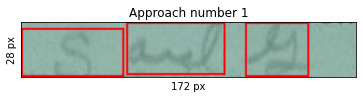

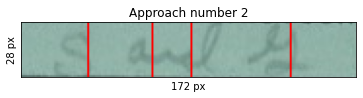

FIELD NAME: SLOPE


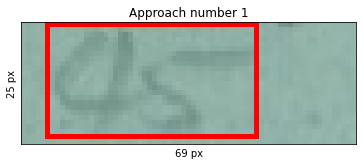

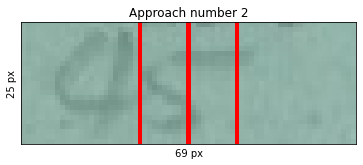

FIELD NAME: ASPECT


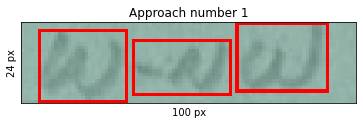

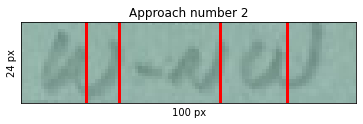

FIELD NAME: LOCATION


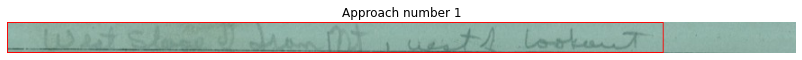

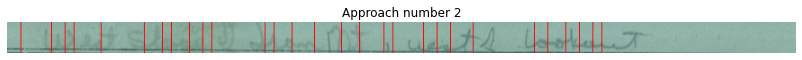

FIELD NAME: ELEVATION


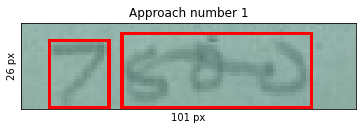

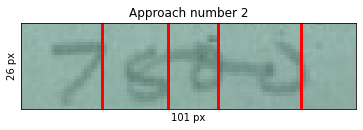

In [28]:
# Compare
for field in fields:
    print(f"FIELD NAME: {field}")
    img = fields[field]
    seg_ps_app_1 = segs_approach_1[field]
    seg_ps_app_2 = segs_approach_2[field]
    
    img_app_1 = img.copy()
    for seg_p in seg_ps_app_1:
        x = seg_p['x']
        y = seg_p['y']
        w = seg_p['w']
        h = seg_p['h']
        img_app_1 = cv2.rectangle(img_app_1, (x, y), (x+w, y+h), (0, 0, 255), 1)
        
    img_app_2 = img.copy()
    for seg_p in seg_ps_app_2:
        seg_p = int(seg_p)
        img_app_2 = cv2.line(img_app_2, (seg_p, 0), (seg_p, img.shape[0]), (0, 0, 255), 1)
    if field == "LOCATION":
        show_image(img_app_1, "Approach number 1", true_size=True)
        show_image(img_app_2, "Approach number 2", true_size=True)
    else:
        show_image(img_app_1, "Approach number 1")
        show_image(img_app_2, "Approach number 2")
    
    

**Conclusion.** Observing this results makes me think that we could combine Floriana's approach (since it works better slicing words) with the one discussed here for slicing characters.

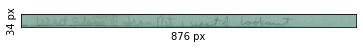

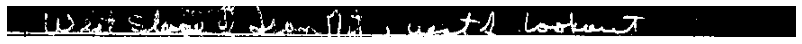

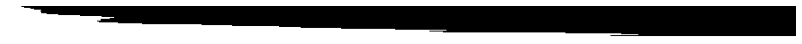

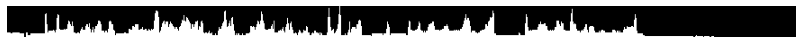

In [85]:
def create_h_v_image_proj(thresh_img):
    h, w = thresh_img.shape[:2]
    h_hist_img = np.zeros(thresh_img.shape[:2], dtype='uint8')
    v_hist_img = np.zeros(thresh_img.shape[:2], dtype='uint8')
    
    word_v_hist_proj = np.sum(thresh_img / 255, axis=0)
    word_h_hist_proj = np.sum(thresh_img / 255, axis=1)
    
    m = np.max(word_h_hist_proj)
    for row in range(thresh_img.shape[0]):
        h_hist_img = cv2.line(
            h_hist_img, 
            (0,row), 
            (int(word_h_hist_proj[row] * w/m),row), 
            (255,255,255), 
            1)
    m = np.max(word_v_hist_proj)
    for col in range(thresh_img.shape[1]):
        v_hist_img = cv2.line(
            v_hist_img, 
            (col,h), 
            (col,h - int(word_v_hist_proj[col]*h/m)), 
            (255,255,255),
            1)
    return h_hist_img, v_hist_img

field = fields['LOCATION']
gray_img = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
_, thresh_img = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
h_hist_img, v_hist_img = create_h_v_image_proj(thresh_img)
show_image(field)
show_image(thresh_img, true_size=True)
show_image(h_hist_img, true_size=True)
show_image(v_hist_img, true_size=True)

In [29]:
# Section 4.4 - Improvement of segmentation points position
# Perform local search around initial segmentation point.
# Final segmentation point will be the one that has the smallest value in the vertical projection vector
def local_search(v_hist, seg_points, length):
    to_ret = []
    for seg_p in seg_points:
        start = int(seg_p - length)
        end = int(seg_p + length + 1)
        if start >= 0 and end <= len(v_hist):
            slice_to_check = v_hist[start:end]
            to_ret.append(start + np.argmin(slice_to_check))
        else:
            to_ret.append(seg_p)
    return to_ret

In [30]:
# Section 4.4 - Baseline detection
# Perform horizontal image projection histogram to detect baseline
# Remove those segmentation points far from the baseline (maybe it prevents slicing W, we'll see)
def baseline_detection(h_hist, seg_points, thresh):
    
    
    return seg_points

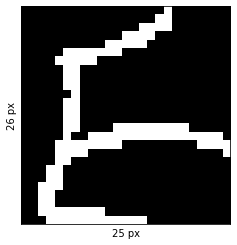

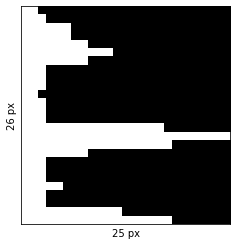

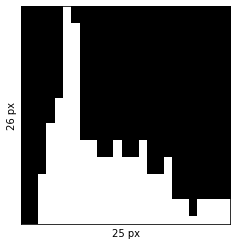

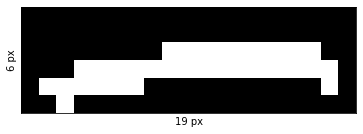

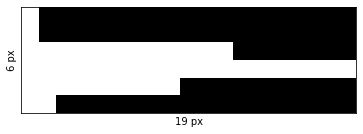

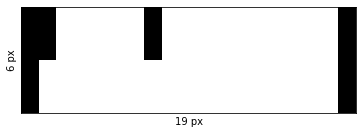

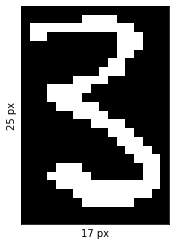

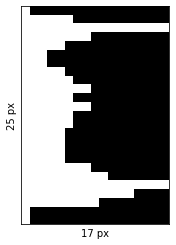

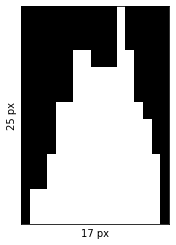

[30]


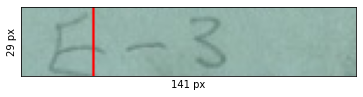

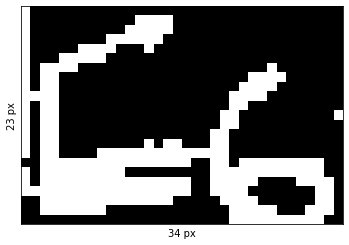

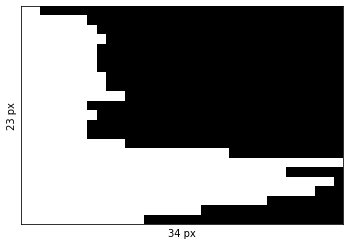

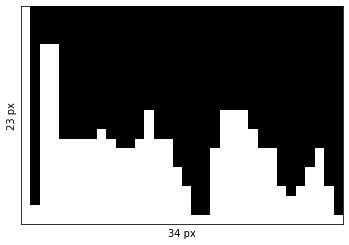

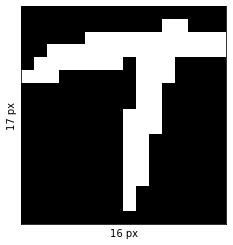

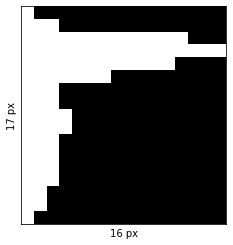

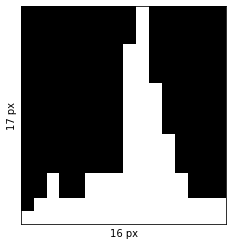

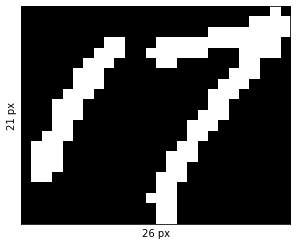

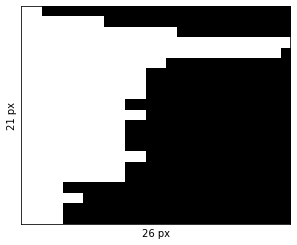

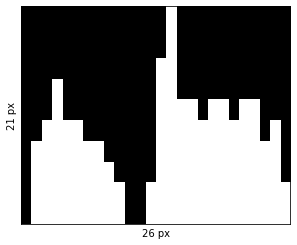

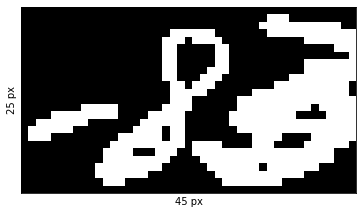

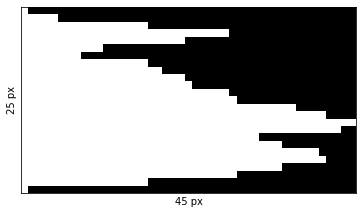

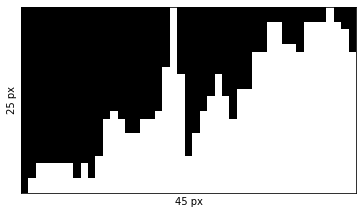

[10]


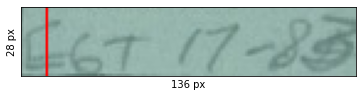

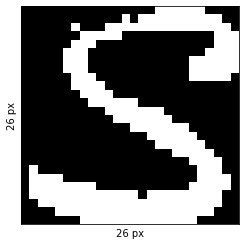

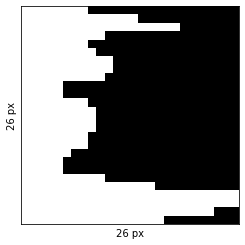

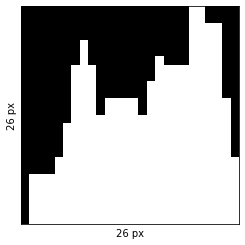

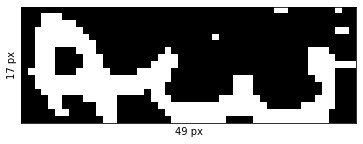

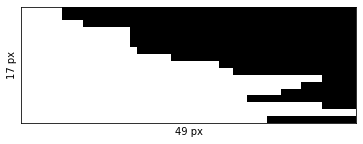

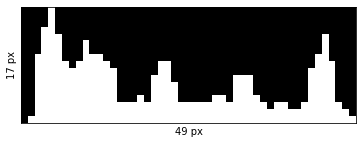

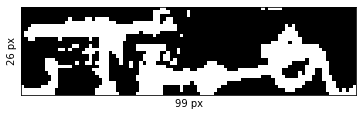

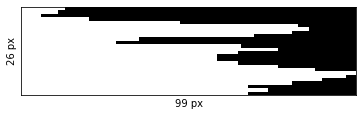

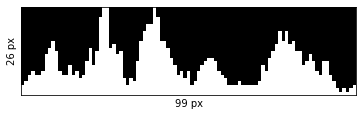

[44, 45, 82, 96, 115, 126, 153]


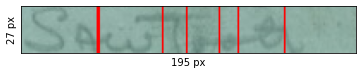

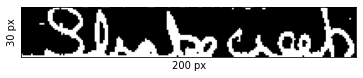

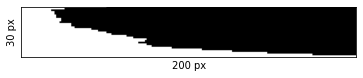

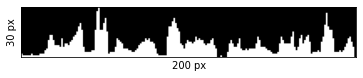

[23, 38, 52, 66, 82, 97, 117, 132, 150, 173, 187]


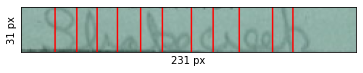

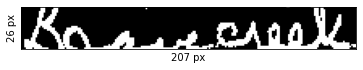

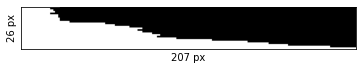

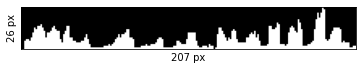

[61, 61, 79, 81, 106, 124, 146, 170, 199, 210, 225, 239]


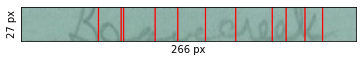

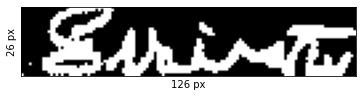

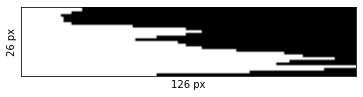

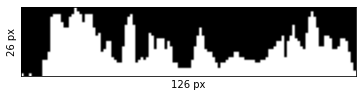

[30, 36, 46, 59, 74, 117]


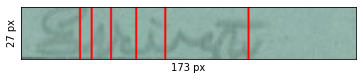

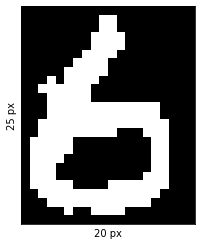

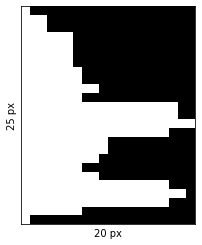

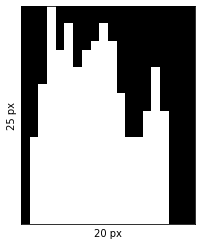

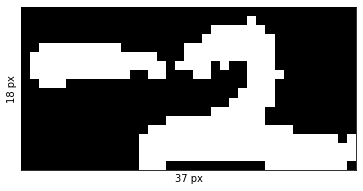

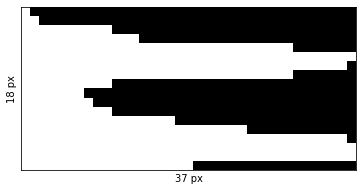

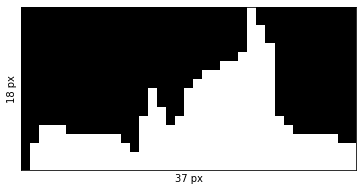

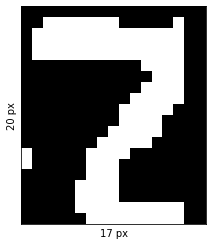

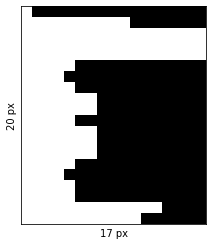

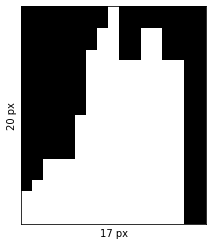

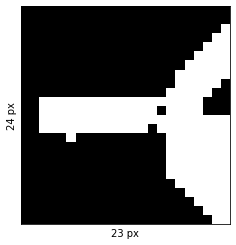

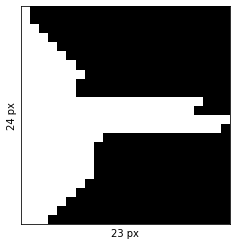

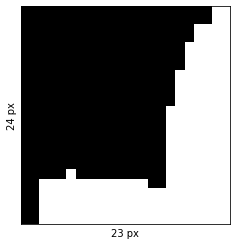

[56]


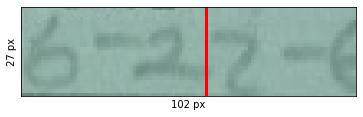

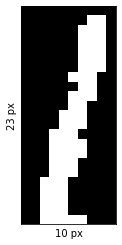

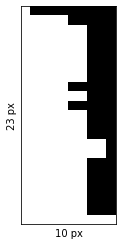

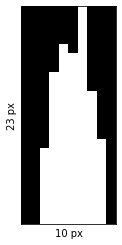

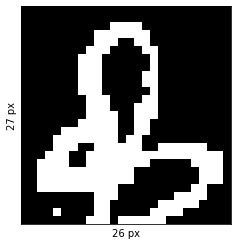

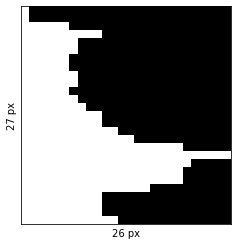

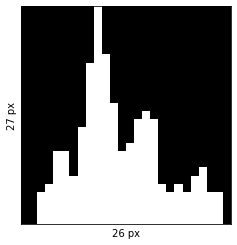

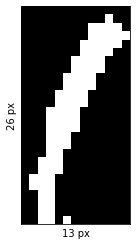

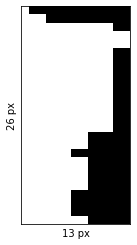

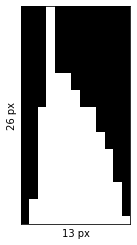

[59]


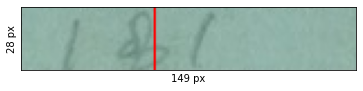

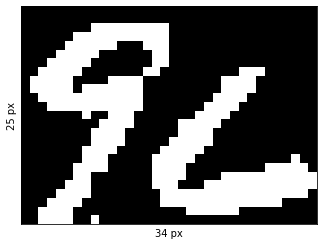

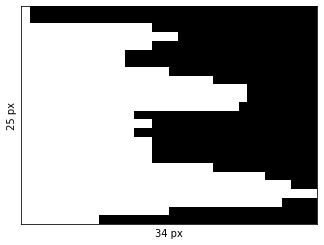

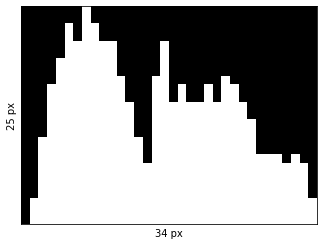

[47, 63]


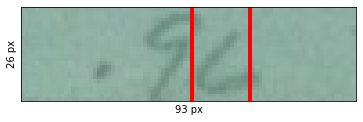

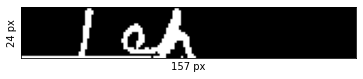

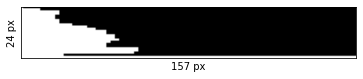

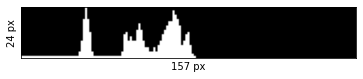

[34, 60, 80, 82]


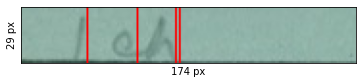

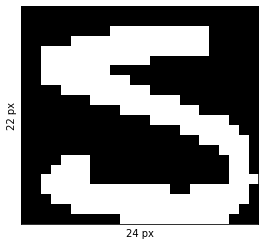

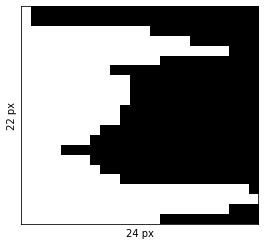

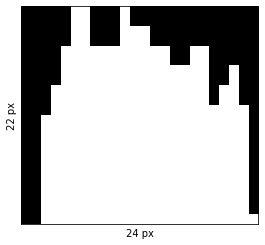

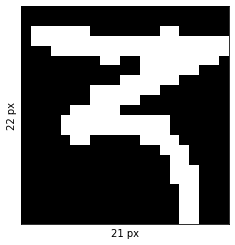

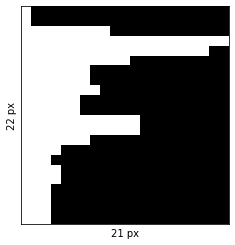

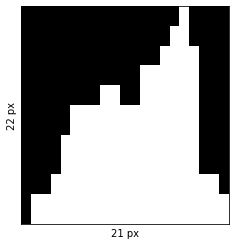

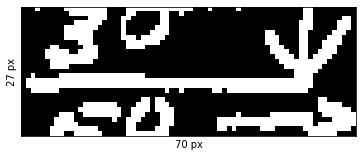

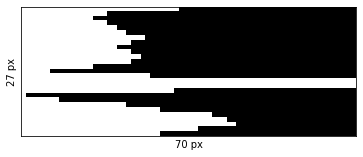

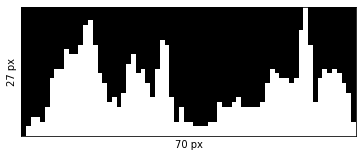

[51, 99, 140, 152]


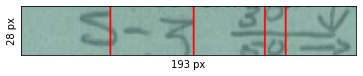

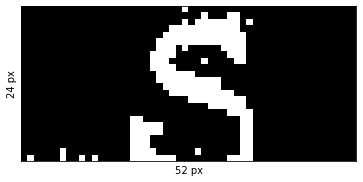

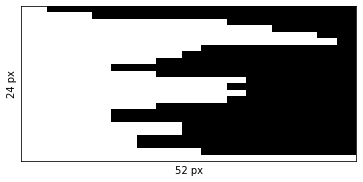

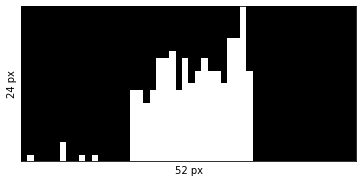

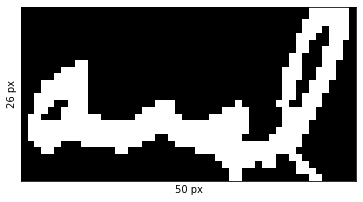

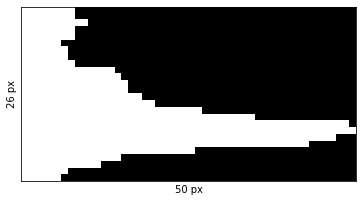

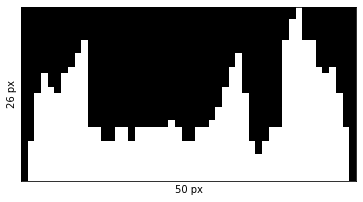

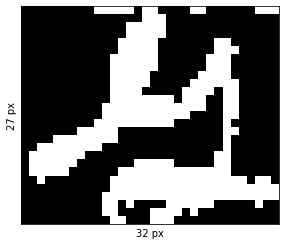

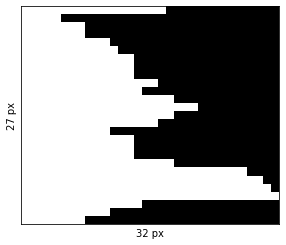

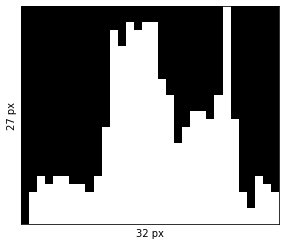

[36, 40, 66, 134]


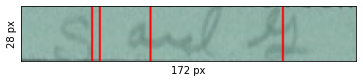

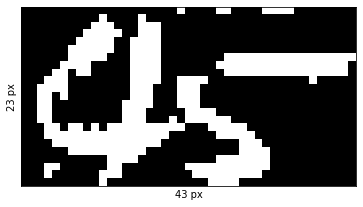

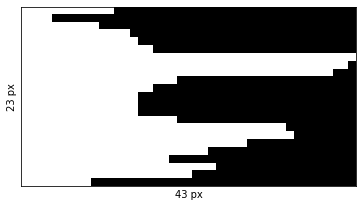

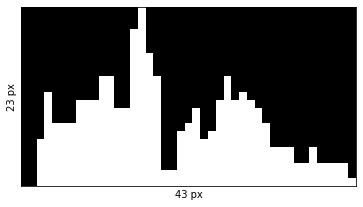

[23, 40]


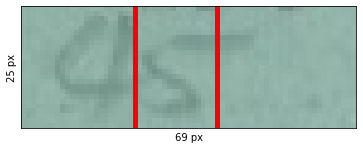

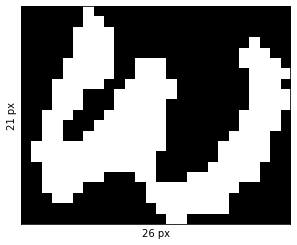

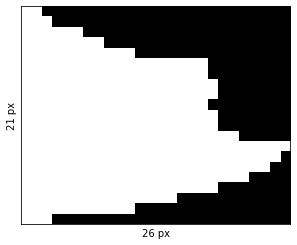

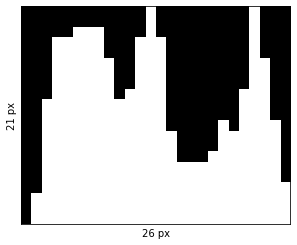

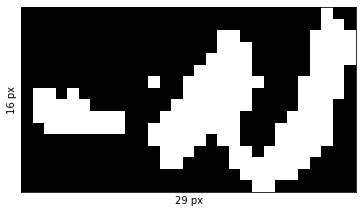

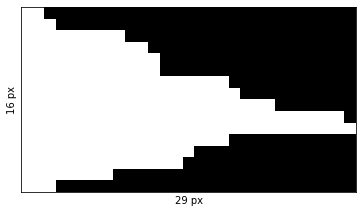

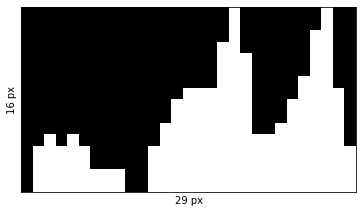

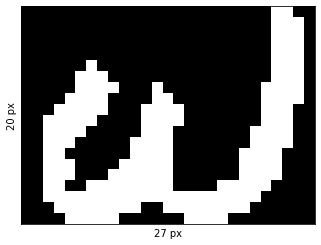

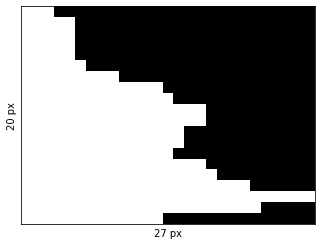

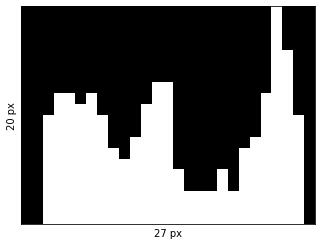

[20, 79]


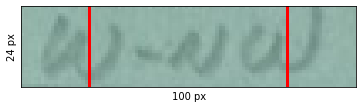

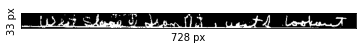

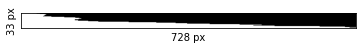

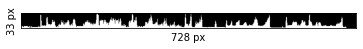

[45, 64, 76, 107, 120, 151, 170, 190, 204, 218, 228, 253, 255, 287, 300, 319, 322, 336, 347, 372, 394, 425, 475, 491, 520, 543, 545, 580, 601, 620, 636, 645, 655, 700, 708]


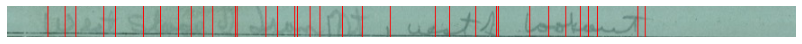

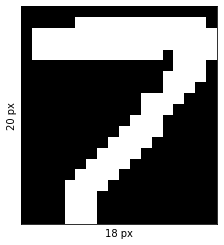

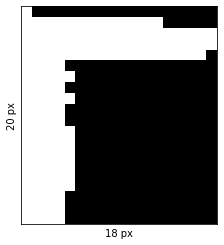

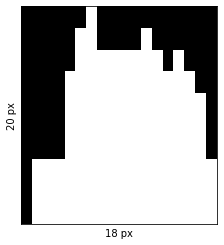

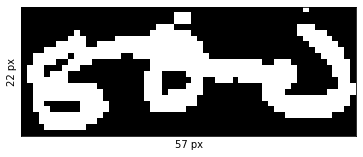

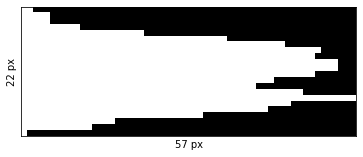

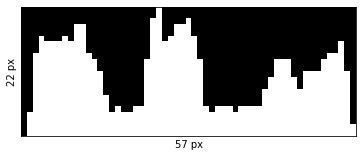

[45, 62]


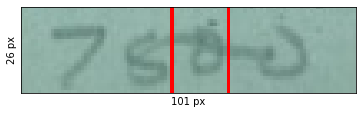

In [94]:
words_positions = segs_approach_1
for field in fields:
    field_img = fields[field]
    field_words = words_positions[field]
    # Find characters in each word
    char_points = []
    for field_word in field_words:
        x = field_word['x']
        y = field_word['y']
        w = field_word['w']
        h = field_word['h']
        word_img = field_img[y:y+h, x:x+w]
        # For each word find the characters
        # Calculate the image vertical projection histogram
        gray_img = cv2.cvtColor(word_img, cv2.COLOR_BGR2GRAY)
        _, thresh_img = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        h_hist_img, v_hist_img = create_h_v_image_proj(thresh_img)
        show_image(thresh_img)
        show_image(h_hist_img)
        show_image(v_hist_img)
        word_v_hist_proj = np.sum(thresh_img / 255, axis=0)
        word_h_hist_proj = np.sum(thresh_img / 255, axis=1)
        # Get characters
        block_size = 10
        if len(word_v_hist_proj) > block_size:
            seg_points = segmentation_points(word_v_hist_proj, block_size, 5, 5)
            # Improve segmentation positions
            seg_points = local_search(word_v_hist_proj, seg_points, block_size // 2)
            # Remove segmentation points far from baseline
            #seg_points = baseline_detection(word_h_hist_proj, seg_points, 10)
            # Update x coordinate in respect of original image
            char_points = char_points + [int(char_x + x) for char_x in seg_points]
    # Draw the slicing on the original image
    print(char_points)
    if char_points:
        segmented = field_img.copy()
        for p in char_points:
            segmented = cv2.line(segmented, (p, 0), (p, field_img.shape[0]), (0, 0, 255), 1)
        if field == "LOCATION":
            show_image(segmented, true_size=True)
        else:
            show_image(segmented)
        